#Εργασία 1. Επιβλεπόμενη Μάθηση: Ταξινόμηση 

##Ομάδα: 86
Σκουρτσή Δήμητρα Άννα: el18044


Στεργιόπουλος Αναστάσιος: el18605


Φιλίππα Μυρσίνη: el18151

## Μέρος 1. UCI dataset

In [1]:
!pip install --upgrade pip #upgrade pip package installer
!pip install scikit-learn --upgrade #upgrade scikit-learn package
!pip install numpy --upgrade #upgrade numpy package
!pip install --upgrade matplotlib # Κάνουμε update την matplotlib
!pip install pandas --upgrade #upgrade pandas package
!pip install -U imbalanced-learn #for imbalanced datasets
!pip install --upgrade matplotlib

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

To data set με το οποίο εργαζόμαστε είναι το HCC Survival Data Set. Περιέχει διάφορα δεδομένα για 165 πραγματικούς ασθενείς που διαγνώσθηκαν με HCC σε ένα πανεπιστημιακό νοσκομείο στην Πορτογαλία.Περιέχει 49 χαρακτηριστικά, 23 των οποίων αποτελούν ποσοτικές μεταβλητές και 26 ποιοτικές.

Οι κατηγορίες εξόδου (target) είναι η επιβίωση (ή οχι) του ασθενή μέσα σε ένα χρόνο, το οποίο έχει κωδικόποιηθεί ως δυαδική μεταβλητή (1: ζει και 0: πεθαίνει).


In [3]:
data = pd.read_csv("final_data.csv", na_values = ["?"], header = [0,1])
print(data)

labels = data.iloc[:,[49]]
features = data.iloc[:,0:49]

np_features = features.values
np_labels = labels.values

#Πλήθος δειγμάτων και χαρακτηριστικών
print('First element: samples and Second element: features')
print(np_features.shape,'\n')

#Οι ετικέτες των κλάσεων βρίσκονται στη τελευταία κολόνα και είναι 
print('The labels of the dataset are: ', set(labels.values.ravel()),'\n')

#Απουσιάζουσες τιμες
totalcounter=0  
for i in range(0,165):
  counter=0
  for j in range(0,49):
    if pd.isna(np_features[i][j]):
      counter+=1
  if counter>0:
    totalcounter+=1
 
print('Number of rows with empty features is', totalcounter)
per=(totalcounter/165)*100
print('Percentage of the above in our dataset is', per,'%\n')

#Πλήθος κλάσεων και τα ποσοστά τους επι του συνόλου
print("frequencies:",np.bincount(np_labels.ravel()))
zeros=0
for i in range(0,165):
  if np_labels[i]==0:
    zeros+=1

perzero=(zeros/165)*100
perone=((165-zeros)/165)*100

print('Percentage of deaths(Class=0)',perzero,'%')
print('Percentage of survivors(Class=1)',perone,'%\n')

     Gender Symptoms Alcohol  ... Oxygen Saturation (%) Ferritin (ng/mL)   Class
    nominal  nominal nominal  ...            continuous       continuous nominal
0         1      0.0       1  ...                   NaN              NaN       1
1         0      NaN       0  ...                   NaN              NaN       1
2         1      0.0       1  ...                   6.0             16.0       1
3         1      1.0       1  ...                   NaN              NaN       0
4         1      1.0       1  ...                  15.0             22.0       1
..      ...      ...     ...  ...                   ...              ...     ...
160       0      0.0       1  ...                   NaN              NaN       1
161       0      1.0       0  ...                   NaN              NaN       0
162       1      0.0       1  ...                   NaN              NaN       1
163       1      0.0       1  ...                   NaN              NaN       0
164       1      1.0       1

Επειδή το ποσοστό των δειγμάτων με απουσιάζουσες τιμές είναι πολύ μεγαλύτερο από 5% (συγκεκριμένα 95%), αν αφαιρούσαμε τα δείγματα αυτά θα θυσιάζαμε τεράστιο όγκο δεδομένων. Επομένως, θα χρησιμοποιήσουμε το μετασχηματιστή imputer για την αντικατάσταση των τιμών αυτών.

Για τα χαρακτηριστικά με binary τιμές χρησιμοποιούμε τη μέθοδο most_frequent, ενώ για αυτά με τις συνεχής τη μέθοδο average.

####Imbalanced Dataset, Oversampling

Καθώς το δείγμα μας έχει αναλογία 38-62 κάνουμε oversampling ώστε να έχουμε ίσο αριθμό δεδομένων για τις δύο περιπτώσεις.
Μια άλλη τεχνική για να το καταφέρουμε αυτό είναι η μέιωση των δεδομένων, όμως καθώς τα δεδομένα μας είναι λίγα προτιμούμε το oversampling.

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [5]:
from warnings import simplefilter
#ignore all future warnings
simplefilter(action='ignore', category=FutureWarning) 
#αυτο το warning βγαίνει επειδή γιατί έχουμε headers σε μορφή tuples 

unique, counts = np.unique(labels, return_counts=True)
print("Before oversampling:",dict(zip(unique, counts)))

ros = RandomOverSampler()
features_sampled, labels_sampled = ros.fit_resample(features, labels)

# Eπιβεβαιώνουμε ότι το training set έχει εξισορροπηθεί με oversampling
unique_after, counts_after = np.unique(labels_sampled, return_counts=True)
print("After oversampling:",dict(zip(unique_after, counts_after)))

Before oversampling: {0: 63, 1: 102}
After oversampling: {0: 102, 1: 102}


In [6]:
from sklearn.model_selection import train_test_split
# Split our data
train, test, train_labels, test_labels = train_test_split(features_sampled, labels_sampled, test_size=0.30)

In [7]:
from warnings import simplefilter
#ignore all future warnings
simplefilter(action='ignore', category=FutureWarning) 
#αυτο το warning βγαίνει επειδή γιατί έχουμε headers σε μορφή tuples 

imp = SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
for i in range(0,49):
  if train.columns.values[i][1] == 'nominal' or train.columns.values[i][1] == 'ordinals':
    temp = train.columns.values[i][0]
    train[temp] = imp.fit_transform(train[[temp]])

for i in range(0,49):
  if test.columns.values[i][1] == 'nominal' or test.columns.values[i][1] == 'ordinals':
    temp = test.columns.values[i][0]
    test[temp] = imp.transform(test[[temp]].values)  

imp = SimpleImputer(missing_values=np.NaN,strategy='mean')

train=pd.DataFrame(imp.fit_transform(train))
train = train.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()
test = imp.transform(test.values) 

label_names = ["dead", "alive"]

###Dummy Classifier: Uniform

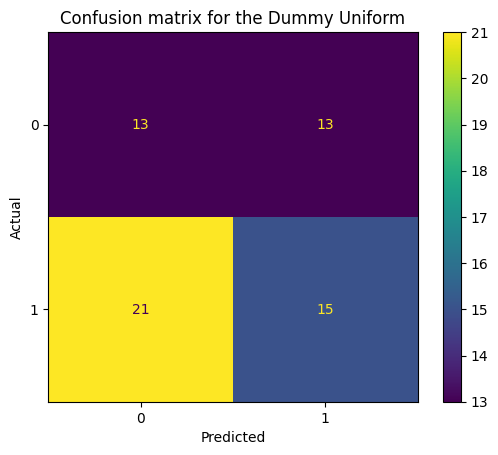

              precision    recall  f1-score   support

        dead       0.46      0.65      0.54        26
       alive       0.64      0.44      0.52        36

    accuracy                           0.53        62
   macro avg       0.55      0.55      0.53        62
weighted avg       0.56      0.53      0.53        62



In [8]:
from sklearn.dummy import DummyClassifier
dc_uniform = DummyClassifier(strategy="uniform")
model = dc_uniform.fit(train, train_labels)
preds = dc_uniform.predict(test)

ConfusionMatrixDisplay.from_estimator(dc_uniform, test, test_labels)  
plt.title('Confusion matrix for the Dummy Uniform')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, preds, target_names=label_names))
accuracy = {}
accuracy['Dummy Uniform']= accuracy_score(test_labels, preds)

f1 = {}
f1['Dummy Uniform'] = f1_score(test_labels, preds)

accuracy_bar = []
accuracy_bar.append(accuracy_score(test_labels, preds))
f1_bar = []
f1_bar.append(f1_score(test_labels, preds))

###Dummy Classifier: Constant(=0)

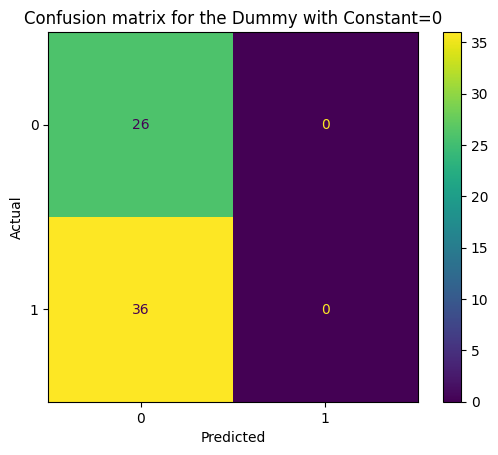

              precision    recall  f1-score   support

        dead       0.42      1.00      0.59        26
       alive       0.00      0.00      0.00        36

    accuracy                           0.42        62
   macro avg       0.21      0.50      0.30        62
weighted avg       0.18      0.42      0.25        62



In [9]:
dc_constant_0 = DummyClassifier(strategy="constant", constant=0)
model = dc_constant_0.fit(train, train_labels)
pred_const0 = dc_constant_0.predict(test)

ConfusionMatrixDisplay.from_estimator(dc_constant_0, test, test_labels)  
plt.title('Confusion matrix for the Dummy with Constant=0')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_const0, zero_division=0, target_names=label_names))
accuracy['Dummy Constant 0']= accuracy_score(test_labels, pred_const0)
f1['Dummy Constant 0'] = f1_score(test_labels, pred_const0)
f1_bar.append(f1_score(test_labels, pred_const0))
accuracy_bar.append(accuracy_score(test_labels, pred_const0))

###Dummy Classifier: Constant(=1)

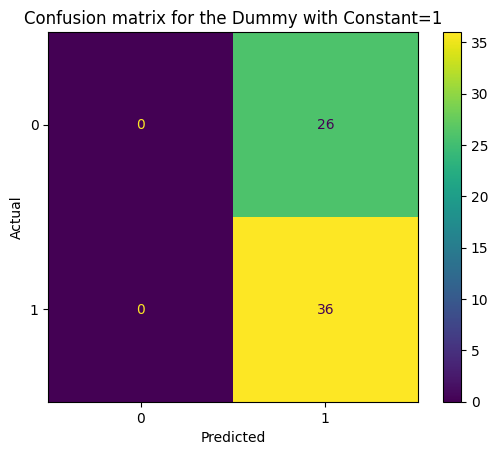

              precision    recall  f1-score   support

        dead       0.00      0.00      0.00        26
       alive       0.58      1.00      0.73        36

    accuracy                           0.58        62
   macro avg       0.29      0.50      0.37        62
weighted avg       0.34      0.58      0.43        62



In [10]:
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
model = dc_constant_1.fit(train, train_labels)
pred_const1 = dc_constant_1.predict(test)

ConfusionMatrixDisplay.from_estimator(dc_constant_1, test, test_labels)  
plt.title('Confusion matrix for the Dummy with Constant=1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_const1, zero_division=0, target_names=label_names))
accuracy['Dummy Constant 1']= accuracy_score(test_labels, pred_const1)
f1['Dummy Constant 1'] = f1_score(test_labels, pred_const1)
f1_bar.append(f1_score(test_labels, pred_const1))
accuracy_bar.append(accuracy_score(test_labels, pred_const1))

###Dummy Classifier: Most Frequent

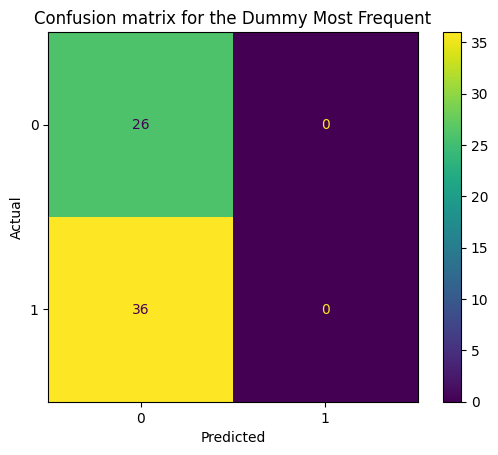

              precision    recall  f1-score   support

        dead       0.42      1.00      0.59        26
       alive       0.00      0.00      0.00        36

    accuracy                           0.42        62
   macro avg       0.21      0.50      0.30        62
weighted avg       0.18      0.42      0.25        62



In [11]:
dc_most_frequent = DummyClassifier(strategy="most_frequent")
model = dc_most_frequent.fit(train, train_labels)
pred_most_freq = dc_most_frequent.predict(test)

ConfusionMatrixDisplay.from_estimator(dc_most_frequent, test, test_labels)  
plt.title('Confusion matrix for the Dummy Most Frequent')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_most_freq, zero_division=0, target_names=label_names))
accuracy['Dummy Most Frequent']= accuracy_score(test_labels, pred_most_freq)
f1['Dummy Most Frequent'] = f1_score(test_labels, pred_most_freq)
f1_bar.append(f1_score(test_labels, pred_most_freq))
accuracy_bar.append(accuracy_score(test_labels, pred_most_freq))

###Dummy Classifier: Stratified

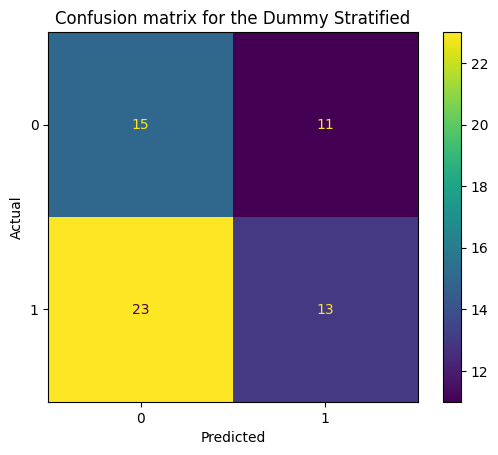

              precision    recall  f1-score   support

        dead       0.36      0.46      0.41        26
       alive       0.52      0.42      0.46        36

    accuracy                           0.44        62
   macro avg       0.44      0.44      0.43        62
weighted avg       0.45      0.44      0.44        62



In [12]:
dc_stratified = DummyClassifier(strategy="stratified")
model = dc_stratified.fit(train, train_labels)
pred_stratified = dc_stratified.predict(test)

ConfusionMatrixDisplay.from_estimator(dc_stratified, test, test_labels)  
plt.title('Confusion matrix for the Dummy Stratified')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_stratified, target_names=label_names))
accuracy['Dummy Stratified']= accuracy_score(test_labels, pred_stratified)
f1['Dummy Stratified'] = f1_score(test_labels, pred_stratified)
f1_bar.append(f1_score(test_labels, pred_stratified))
accuracy_bar.append(accuracy_score(test_labels, pred_stratified))

###Gaussian Naive Bayes Classifier

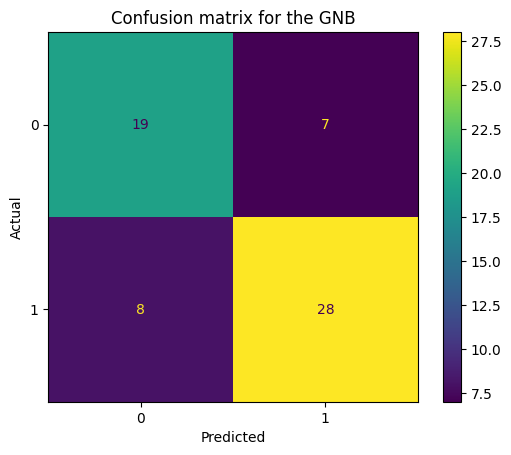

              precision    recall  f1-score   support

        dead       0.70      0.73      0.72        26
       alive       0.80      0.78      0.79        36

    accuracy                           0.76        62
   macro avg       0.75      0.75      0.75        62
weighted avg       0.76      0.76      0.76        62



In [13]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
# κάνουμε εκπαίδευση (fit) δηλαδή ουσιαστικά υπολογίζουμε μέση τιμή και διακύμανση για όλα τα χαρακτηριστικά και κλάσεις στο training set

model = gnb.fit(train, train_labels.ravel())
pred_gnb = gnb.predict(test)

ConfusionMatrixDisplay.from_estimator(gnb, test, test_labels)  
plt.title('Confusion matrix for the GNB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_gnb, target_names=label_names))
accuracy['Gaussian Naive Bayes']= accuracy_score(test_labels, pred_gnb)
f1['Gaussian Naive Bayes'] = f1_score(test_labels, pred_gnb)
f1_bar.append(f1_score(test_labels, pred_gnb))
accuracy_bar.append(accuracy_score(test_labels, pred_gnb))

###k-Nearest-Neighbors Classifier

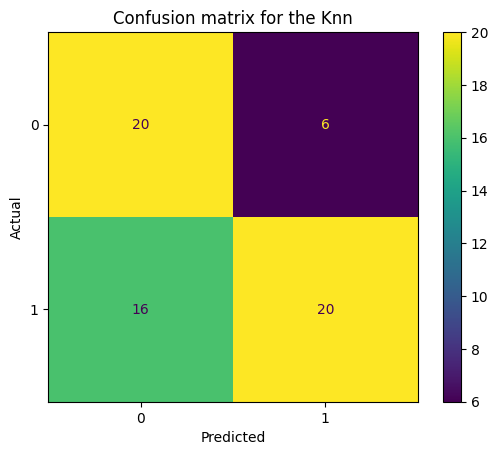

              precision    recall  f1-score   support

        dead       0.56      0.77      0.65        26
       alive       0.77      0.56      0.65        36

    accuracy                           0.65        62
   macro avg       0.66      0.66      0.65        62
weighted avg       0.68      0.65      0.65        62



In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train, train_labels.ravel())
predk = knn.predict(test)

ConfusionMatrixDisplay.from_estimator(knn, test, test_labels)  
plt.title('Confusion matrix for the Knn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, predk, target_names=label_names))
accuracy['K Neighbours']= accuracy_score(test_labels, predk)
f1['K Neighbours'] = f1_score(test_labels, predk)
f1_bar.append(f1_score(test_labels, predk))
accuracy_bar.append(accuracy_score(test_labels, predk))
compare=[]
compare.append(accuracy_score(test_labels, predk))
compare.append(f1_score(test_labels, predk))
markdown_Knn={}
markdown_Knn['Accuracy Score for Not Optimized Knn'] = accuracy_score(test_labels, predk)
markdown_Knn['F1 for Not Optimized Knn'] = f1_score(test_labels, predk)

###Logistic Regression Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


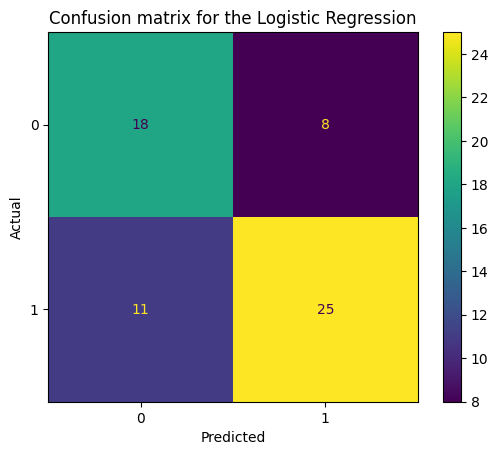

              precision    recall  f1-score   support

        dead       0.62      0.69      0.65        26
       alive       0.76      0.69      0.72        36

    accuracy                           0.69        62
   macro avg       0.69      0.69      0.69        62
weighted avg       0.70      0.69      0.70        62



In [15]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(train, train_labels.ravel())
predictions = logisticRegr.predict(test)

ConfusionMatrixDisplay.from_estimator(logisticRegr, test, test_labels)  
plt.title('Confusion matrix for the Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, predictions, target_names=label_names, zero_division = 0))
accuracy['Logistic Regression']= accuracy_score(test_labels, predictions)
f1['Logistic Regression'] = f1_score(test_labels, predictions)
f1_bar.append(f1_score(test_labels, predictions))
accuracy_bar.append(accuracy_score(test_labels, predictions))
compare.append(accuracy_score(test_labels, predictions))
compare.append(f1_score(test_labels, predictions))
markdown_LR={}
markdown_LR['Accuracy Score for Not Optimized Logistic Regression'] = accuracy_score(test_labels, predictions)
markdown_LR['F1 for Not Optimized Logistic Regression'] = f1_score(test_labels, predictions)

###Επίδοση out-of-the-box για όλους τους classifiers σε φθίνουσα σειρά

In [16]:
print("Classification Accuracy on the Portugal HCC Dataset (30% test set)\n")
sorted_accuracy = [(k, accuracy[k]) for k in sorted(accuracy, key=accuracy.get, reverse=True)]
for k, v in sorted_accuracy:
  print(k,":",v)
print("\n")

print("Classification F1 on the Portugal HCC Dataset (30% test set)\n")
sorted_f1 = [(k, f1[k]) for k in sorted(f1, key=f1.get, reverse=True)]
for k, v in sorted_f1:
  print(k,":",v)
print("\n")

Classification Accuracy on the Portugal HCC Dataset (30% test set)

Gaussian Naive Bayes : 0.7580645161290323
Logistic Regression : 0.6935483870967742
K Neighbours : 0.6451612903225806
Dummy Constant 1 : 0.5806451612903226
Dummy Uniform : 0.532258064516129
Dummy Stratified : 0.43548387096774194
Dummy Constant 0 : 0.41935483870967744
Dummy Most Frequent : 0.41935483870967744


Classification F1 on the Portugal HCC Dataset (30% test set)

Gaussian Naive Bayes : 0.7887323943661971
Dummy Constant 1 : 0.7346938775510204
Logistic Regression : 0.7246376811594203
K Neighbours : 0.6451612903225806
Dummy Uniform : 0.5245901639344263
Dummy Stratified : 0.46153846153846156
Dummy Constant 0 : 0.0
Dummy Most Frequent : 0.0




###Επίδοση out-of-the-box σε bar plots σύγκρισης

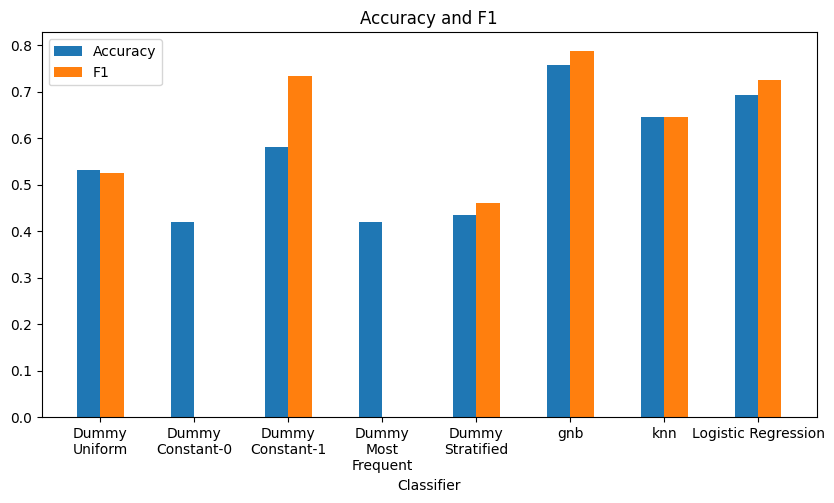

In [17]:
classifiers = ['Dummy\nUniform', 'Dummy\nConstant-0', 'Dummy\nConstant-1', 'Dummy\nMost\nFrequent', 'Dummy\nStratified', 'gnb','knn','Logistic Regression']
 
plt.figure(figsize=(10,5)) 
X_axis = np.arange(len(classifiers))
  
plt.bar(X_axis - 0.125, accuracy_bar, 0.25, label = 'Accuracy')
plt.bar(X_axis + 0.125, f1_bar, 0.25, label = 'F1')
  
plt.xticks(X_axis, classifiers)
plt.xlabel("Classifier")
plt.title("Accuracy and F1")
plt.legend()
plt.show()




* Ο Dummy Classifier Most Frequent διαλέγει πάντα το Most Frequent Label του train και έπειτα το εφαρμόζει στο test. Καθώς το dataset μας που χωρίζεται σε Train και Test είναι ισοροπημένο, αυτός ο dummy θα έχει πάντα τη χειρότερη επίδοση, αφού όταν υπερτερούν οι περιπτώσεις "alive" στο train, στο test θα υπερτερούν οι περιπτώσεις "dead", και το αντίστροφο.
* Ο kNN έχει καλύτερη επίδοση από όλους τους dummy, καθώς είναι βασισμένος σε έναν αλγόριθμο λογικής ανάλυσης των δεδομένων. Λόγω του μεγέθους του dataset οι γείτονες του κάθε χαρακτηριστικού δεν είναι αντιπροσωπευτικοί και για αυτό δεν παρατηρείται μεγάλη βελτίωση.
* Τις περισσότερες φορές ο Gaussian Naive Bayes τις περισσότερες φορές έχει την καλύτερη επίδοση, όμως δεν ισχύει πάντα αυτό λόγω του μικρού μεγέθους του δείγματος.
* Ο Logistic Regression έχει συνήθως καλή επίδοση, το μικρό μέγεθος του dataset οδηγεί σε μη-σταθερά ποσοστά accuracy σε διαφορετικά runs.






###Βελτιστοποίηση

Θα ασχοληθούμε με τη βελτιστοποίηση των ταξινομητών kNN και LR, οι οποίοι με τις σωστές προσαρμογές μπορούν να δώσουν καλύτερα αποτελέσματα. Οι dummy classifiers δεν θα μας απασχολήσουν καθώς δεν επηρεάζονται από την επεξεργασία των δεδομένων και δεν έχουν κάποια υπερπαράμετρο την οποία μπορούμε να βελτιστοποιήσουμε. Όσον αφορά τον ταξινομητή GauusianNB, λόγω της δομής του αλγορίθμου δεν επηρεάζεται ιδιαίτερα (ή και καθόλου) από την προεπεξεργασία των δεδομένων στο συγκεκριμένο dataset. Επίσης, δεν έχει κάποια υπερπαράμετρο που να μπορούμε να βελτιστοποιήσουμε.



####Κανονικοποίηση

Θα κάνουμε κανονικοποίησ με τον standar scaler ώστε τα δεδομένα μας να έχουν διακύμανση 1 και μέση τιμή 0.

In [18]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

####Variance Threshold
Μία από τις τεχνικές επιλογής χαρακτηριστικών είναι το ελάχιστον κατώφλι της διακύμανσης (Variance Threshold). Αν η διακύμανση ενός χαρακτηριστικού είναι πολύ χαμηλή, δεν μπορεί να προσφέρει σημαντικά στη διαχωριστική ικανότητα του ταξινομητή. Ειδικά στην περίπτωση όπου η διακύμανση είναι μηδέν (κάποιο χαρακτηριστικό με σταθερή τιμή), το χαρακτηριστικό αυτό δεν χρησιμεύει καθόλου. 

Θα χρησιμοποιήσουμε, λοιπόν, τη συνάρτηση VarianceThershold() για να αφαιρέσουμε χαρακτηριστικά με μηδενική διακύμανση και θα προσθέσουμε μία μάσκα των χαρακτηριστικών που τελικά κρατάμε για να την εφαρμόσουμε και στο test set ώστε τελικά να έχουν ίδιες διαστάσεις.

In [19]:
selector = VarianceThreshold()
train_reduced = selector.fit_transform(train_scaled)
mask = selector.get_support()
print(mask)
test_reduced = selector.transform(test_scaled)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


####Ανάλυση σε κύριες συνιστώσες (PCA)
Μία ακόμα μέθοδος επιλογής χαρακτηριστικών με στόχο τη μείωση της διαστατικότητας τους, είναι η εξαγωγή νέων χαρακτηριστικών σε ένα χώρο μικρότερων διαστάσεων. Για το σκοπό αυτό θα χρησιμοποιήσουμε την ανάλυση σε κύριες συνιστώσες (PCA), στην οποία αναλύουμε τα δεδομένα σε κύριες συνιστώσες και δουλεύουμε με νέες, γραμμικά ασυσχέτιστες μεταβλητές μικρότερης διαστατικότητας. 

In [20]:
from sklearn.decomposition import PCA
n = 49
pca = PCA(n_components=n)

trainPCA = pca.fit_transform(train_reduced)
testPCA = pca.transform(test_reduced)

print(trainPCA.shape)

(142, 49)


[0.10442325 0.18083214 0.24879197 0.30893304 0.36678869 0.40991449
 0.4502098  0.48715713 0.52148935 0.5537448  0.58447088 0.61211024
 0.63855701 0.66341682 0.6868554  0.70917978 0.73037287 0.75087053
 0.77010866 0.78767676 0.80428447 0.81959295 0.83460179 0.84783696
 0.86079304 0.87284767 0.88446694 0.89579672 0.90572287 0.91480943
 0.92307779 0.93109175 0.93883855 0.94592095 0.95285927 0.95916918
 0.9646524  0.96999718 0.97473008 0.97911778 0.98277347 0.98622625
 0.98915915 0.99186756 0.99434794 0.99661936 0.99873668 0.99982151
 1.        ]


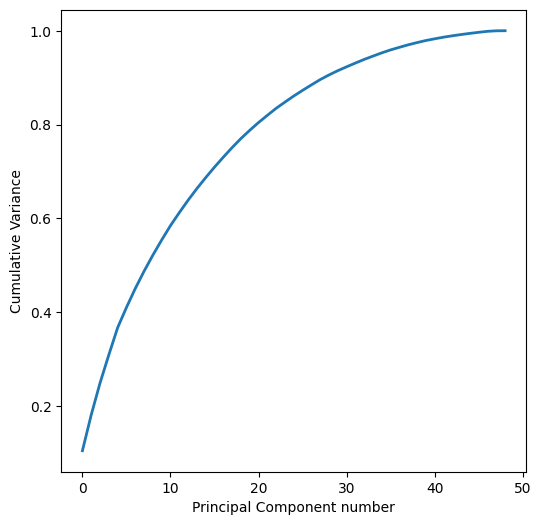

In [21]:
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(6, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

Παρατηρούμε ότι με 25 συνιστώσες περιγράφουμε το 80% της διακύμνασης του dataset, ενώ με 40 συνιστώσες περιγράφουμε σχεδόν το 100%.
</br> Ο αριθμός των συνιστωσών που κρατάμε είναι μια από τις υπερπαραμέτρους που θα προσδιοριστεί μέσω του Cross Validation.

####Επιδόσεις Knn με κανονικοποιημένα δεδομένα

In [22]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier() 
knn.fit(train, train_labels.ravel())
knn_pred = knn.predict(test)

knn.fit(trainPCA, train_labels.ravel())
knn_pred_scaled = knn.predict(testPCA)

print("kNN Before")
print(classification_report(test_labels,knn_pred))

print("kNN After and Normalization, Variance Threshold and PCA")
print(classification_report(test_labels,knn_pred_scaled))

kNN Before
              precision    recall  f1-score   support

           0       0.56      0.77      0.65        26
           1       0.77      0.56      0.65        36

    accuracy                           0.65        62
   macro avg       0.66      0.66      0.65        62
weighted avg       0.68      0.65      0.65        62

kNN After and Normalization, Variance Threshold and PCA
              precision    recall  f1-score   support

           0       0.67      0.54      0.60        26
           1       0.71      0.81      0.75        36

    accuracy                           0.69        62
   macro avg       0.69      0.67      0.67        62
weighted avg       0.69      0.69      0.69        62



####Επιδόσεις Logistic Regression με κανονικοποιημένα δεδομένα

In [23]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train, train_labels.ravel())
logisticRegr_pred = logisticRegr.predict(test)

logisticRegr.fit(trainPCA, train_labels.ravel())
logisticRegr_pred_scaled = logisticRegr.predict(testPCA)

print("Logistic Regression Before")
print(classification_report(test_labels,logisticRegr_pred))

print("Lοgistic Regression After Normalization, Variance Threshold and PCA")
print(classification_report(test_labels,logisticRegr_pred_scaled))

Logistic Regression Before
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        26
           1       0.76      0.69      0.72        36

    accuracy                           0.69        62
   macro avg       0.69      0.69      0.69        62
weighted avg       0.70      0.69      0.70        62

Lοgistic Regression After Normalization, Variance Threshold and PCA
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        26
           1       0.71      0.75      0.73        36

    accuracy                           0.68        62
   macro avg       0.67      0.66      0.66        62
weighted avg       0.67      0.68      0.68        62



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##Cross Validation

Για να βρούμε τις βέλτιστες υπερπαραμέτρους για τους Knn και Logical Regression κάνουμε χρήση της συνάρτησης GridSearchCV, η οποία κάνει Cross Validation με 10 folds, στην οποία δίνουμε ως όρισμα ένα Pipeline, που περιέχει όλες τις διαφορετικές προεπεξεργασίες δεδομένων που θέλουμε να δοκιμάσουμε, καθώς και τις διαφορετικές τιμές για τις υπερπαραμέτρους.

####Cross Validation για Knn

In [24]:
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [25]:
# Αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
scaler = StandardScaler()
pca = PCA()
clf = neighbors.KNeighborsClassifier(n_jobs=-1) # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή

pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector), ('pca', pca), ('kNN', clf)])

In [26]:
vthreshold = [ 0, 0.1, 0.2, 1, 5, 20, 500, 10000 ] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [7, 15, 20, 25, 30, 35, 40, 45, 49]
k = [1, 3, 5, 7, 9, 11] # η υπερπαράμετρος του ταξινομητή

estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    pca__n_components=n_components, 
                                    kNN__n_neighbors=k), 
                                    cv=10, 
                                    scoring='f1_macro', 
                                    n_jobs=-1,
                                    verbose=1)

In [27]:
# Απενεργοποιούμε τις προειδοποιήσεις 
import warnings
warnings.filterwarnings("ignore")

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


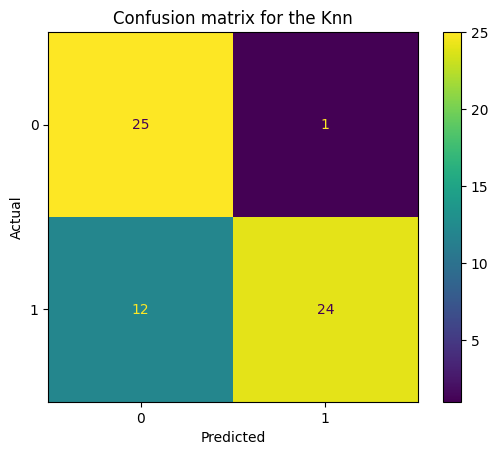

              precision    recall  f1-score   support

           0       0.68      0.96      0.79        26
           1       0.96      0.67      0.79        36

    accuracy                           0.79        62
   macro avg       0.82      0.81      0.79        62
weighted avg       0.84      0.79      0.79        62



In [28]:
start_time = time.time()
estimator.fit(train, train_labels)
markdown_Knn['Time Fit Knn'] = time.time() - start_time
start_time = time.time()
preds = estimator.predict(test)
markdown_Knn['Time Test Knn'] = time.time() - start_time

ConfusionMatrixDisplay.from_estimator(estimator, test, test_labels)  
plt.title('Confusion matrix for the Knn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, preds))
compare_new=[]
compare_new.append(accuracy_score(test_labels, preds))
compare_new.append(f1_score(test_labels, preds))
markdown_Knn['Accuracy Score for Optimized Knn'] = accuracy_score(test_labels, preds)
markdown_Knn['F1 for Optimized Knn'] = f1_score(test_labels, preds)

In [29]:
# Best combination
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=20)),
                ('kNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=1))])
{'kNN__n_neighbors': 1, 'pca__n_components': 20, 'selector__threshold': 0}


####Cross Validation για Logical Regression

In [30]:
logisticRegr = LogisticRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector), ('pca', pca), ('logisticregression', logisticRegr)])
vthreshold = [ 0, 0.1, 0.2, 1, 5, 20, 500, 10000 ] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [7, 15, 20, 25, 30, 35, 40, 45, 49]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # η υπερπαράμετρος του ταξινομητή

estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    pca__n_components=n_components, 
                                    logisticregression__C=C), 
                                    cv=10, 
                                    scoring='accuracy', 
                                    n_jobs=-1,
                                    verbose=1)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits


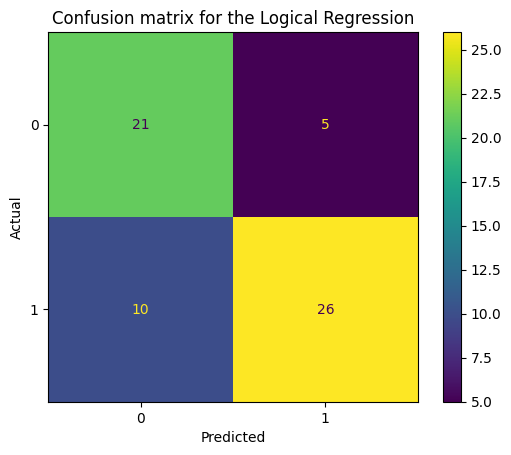

              precision    recall  f1-score   support

           0       0.68      0.81      0.74        26
           1       0.84      0.72      0.78        36

    accuracy                           0.76        62
   macro avg       0.76      0.76      0.76        62
weighted avg       0.77      0.76      0.76        62



In [31]:
start_time = time.time()
estimator.fit(train, train_labels)
markdown_LR['Time Fit Logistic Regression'] = time.time() - start_time
start_time = time.time()
preds = estimator.predict(test)
markdown_LR['Time Test Logistic Regression'] = time.time() - start_time

ConfusionMatrixDisplay.from_estimator(estimator, test, test_labels)  
plt.title('Confusion matrix for the Logical Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, preds))
compare_new.append(accuracy_score(test_labels, preds))
compare_new.append(f1_score(test_labels, preds))
markdown_LR['Accuracy Score for Optimized Logistic Regression'] = accuracy_score(test_labels, preds)
markdown_LR['F1 for Optimized Logistic Regression'] = f1_score(test_labels, preds)

In [32]:
# Best combination
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=7)),
                ('logisticregression', LogisticRegression(C=1))])
{'logisticregression__C': 1, 'pca__n_components': 7, 'selector__threshold': 0}


####Bar διάγραμμα συγκρίσης μετρικών

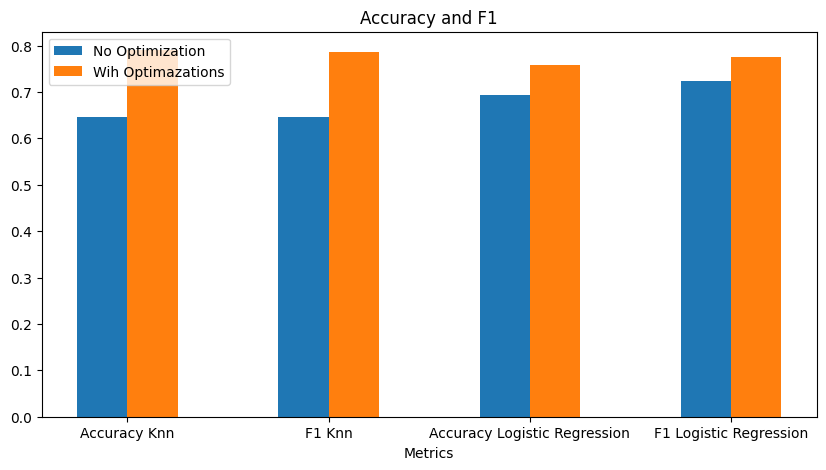

In [33]:
metrics = ['Accuracy Knn', 'F1 Knn', 'Accuracy Logistic Regression', 'F1 Logistic Regression']
plt.figure(figsize=(10,5)) 
X_axis = np.arange(len(metrics))
  
plt.bar(X_axis - 0.125, compare, 0.25, label = 'No Optimization')
plt.bar(X_axis + 0.125, compare_new, 0.25, label = 'Wih Optimazations')
  
plt.xticks(X_axis, metrics)
plt.xlabel("Metrics")
plt.title("Accuracy and F1")
plt.legend()
plt.show()

####Markdown table για σύγκριση επιδόσεων

In [34]:
# print(markdown)
print("Classification Accuracy on the Portugal HCC Dataset (30% test set)\n")
prt_markdown_Knn = [(k, markdown_Knn[k]) for k in markdown_Knn]
for k, v in prt_markdown_Knn:
  print(k,":",v)
print("\n")
prt_markdown_LR = [(k, markdown_LR[k]) for k in markdown_LR]
for k, v in prt_markdown_LR:
  print(k,":",v)

Classification Accuracy on the Portugal HCC Dataset (30% test set)

Accuracy Score for Not Optimized Knn : 0.6451612903225806
F1 for Not Optimized Knn : 0.6451612903225806
Time Fit Knn : 100.55765867233276
Time Test Knn : 0.1068878173828125
Accuracy Score for Optimized Knn : 0.7903225806451613
F1 for Optimized Knn : 0.7868852459016393


Accuracy Score for Not Optimized Logistic Regression : 0.6935483870967742
F1 for Not Optimized Logistic Regression : 0.7246376811594203
Time Fit Logistic Regression : 26.658018350601196
Time Test Logistic Regression : 0.0006184577941894531
Accuracy Score for Optimized Logistic Regression : 0.7580645161290323
F1 for Optimized Logistic Regression : 0.7761194029850746


####Σχολιασμός

Τις περισσότερες φορές έχουμε βελτίωση στο accuracy του Knn και του Logistic Regression. Παρατηρούμε, όμως, ότι υπάρχουν και φορές που δεν υπάρχει βελτίωση. Αυτό οφείλεται στον μικρό μέγεθεος του dataset (165 δείγματα). Οι διαφορές που παρατηρούνται ανάμεσα σε διαφορετικά runs οφείλονται στο random split του dataset σε train και test, καθώς και στο random oversampling.

